In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal
%run StreamClass.ipynb

[[96.         -2.59371322 51.450811  ]
 [93.         -2.59374641 51.45068318]
 [89.         -2.5938143  51.4505028 ]
 [85.         -2.59391606 51.45028948]
 [81.         -2.59406861 51.45007415]
 [78.         -2.59418068 51.44998111]
 [74.         -2.59444412 51.44991078]
 [71.         -2.59470999 51.44993392]
 [68.         -2.59495935 51.44999343]
 [64.         -2.59518064 51.45002939]
 [62.         -2.5952777  51.45003844]
 [58.         -2.59543    51.45004976]
 [57.         -2.59546462 51.45005235]
 [55.         -2.59554634 51.45007406]
 [50.         -2.59570467 51.45016249]
 [49.         -2.59570124 51.4502018 ]
 [45.         -2.59567081 51.45038537]
 [41.         -2.5956289  51.45057161]
 [37.         -2.59556981 51.45078963]
 [33.         -2.59550971 51.45099792]
 [29.         -2.59539756 51.45111275]
 [26.         -2.59522808 51.45109381]
 [21.         -2.59492046 51.45107335]
 [17.         -2.59467102 51.45106321]
 [13.         -2.59439894 51.45105617]
 [ 9.         -2.59412879

## Plot each variable on a graph

In [2]:
data = Data_Stream("data5.csv")
print(data.acc_DRC.shape)
# data.plot()

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
(4760, 4)


## Kalman Filter Implementation

In [9]:
def getQ(acc_stddev, dt):
    vel_stddev = acc_stddev*dt
    dis_stddev = 0.5*acc_stddev*dt**2
    Q = (dis_stddev**2)*np.identity(4)
    Q[2, 2] = vel_stddev**2
    Q[3, 3] = vel_stddev**2
    Q[0, 2] = dis_stddev*vel_stddev
    Q[1, 3] = dis_stddev*vel_stddev
    return Q

def getFkBk(Fk, Bk, dt):
    Fk[0, 2] = dt
    Fk[1, 3] = dt
    Bk[0, 0] = 0.5*dt**2
    Bk[1, 1] = 0.5*dt**2
    Bk[2, 0] = dt
    Bk[3, 1] = dt
    return Fk, Bk

def kalman_predict(dt, Fk, Bk, xk, uk, Pk, acc_stddev):
    Q = getQ(acc_stddev, dt)
    Fk, Bk = getFkBk(Fk, Bk, dt)
    xk = np.matmul(Fk, xk) + np.matmul(Bk, uk)
    Pk = np.matmul(np.matmul(Fk, Pks[-1]), Fk.T) + Q
    return xk, Pk, Fk, Bk

def kalman_gain(Pk, H, R):
    PkHT = np.matmul(Pk, H.T)
    K = np.matmul(PkHT, np.linalg.inv(np.matmul(H, PkHT)+R))
    return K

def kalman_update_state(xk, zk, K, H):
    Hxk = np.matmul(H, xk)
    zk = np.concatenate((zk, np.asmatrix([0])))
    zk = np.concatenate((zk, np.asmatrix([0])))
    return xk+np.matmul(K, zk-Hxk )

def kalman_update_uncertainty(Pk, K, H):
    return Pk - np.matmul(K, np.matmul(H, Pk))

def compute_kalman(data):
    ## Assume that the initial state is position (0, 0) and velocity (0, 0)
    x0 = np.asmatrix([0, 0, 0, 0]).T
    xks = [x0]
    u0 = data.acc_ERC[0, 1:3].T
    uks = [u0]
    Fk = np.asmatrix(np.identity(4))
    Bk = np.zeros((4, 2))

    acc_stddev = 0.6

    P0 = np.zeros((4, 4))
    Pks = [P0]

    H = np.identity(4)
    H[2, 2] = 0.0
    H[3, 3] = 0.0
    gps_var = 15.2
    R = gps_var*np.identity(4)
    
    for i in range(1, data.acc_DRC.shape[0]):
        dt = data.acc_DRC[i, 0] - data.acc_DRC[i-1, 0]
        xk, Pk, Fk, Bk = kalman_predict(dt, Fk, Bk, xks[-1], uks[-1], Pks[-1], acc_stddev)
        xks.append(xk)
        uks.append(data.acc_ERC[i, 1:3].T)
        Pks.append(Pk)
        zk = data.gps[i, 1:3].T

        K = kalman_gain(Pks[-1], H, R)
        xks[-1] = kalman_update_state(xk, zk, K, H)
        Pks[-1] = kalman_update_uncertainty(Pks[-1], K, H)
        
    xks = [xk.T for xk in xks]
    xks = np.concatenate(xks)
    data.init_kalman(xks)

In [13]:
data = Data_Stream("data5.csv", load_truth=True)
compute_kalman(data)

data = data.create_reverse()
compute_kalman(data)



Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


Plot Kalman Filter output against original Sensor Input

Text(0.5, 1.0, 'Velocity Y (Integration of Uncorrected Acceleration)')

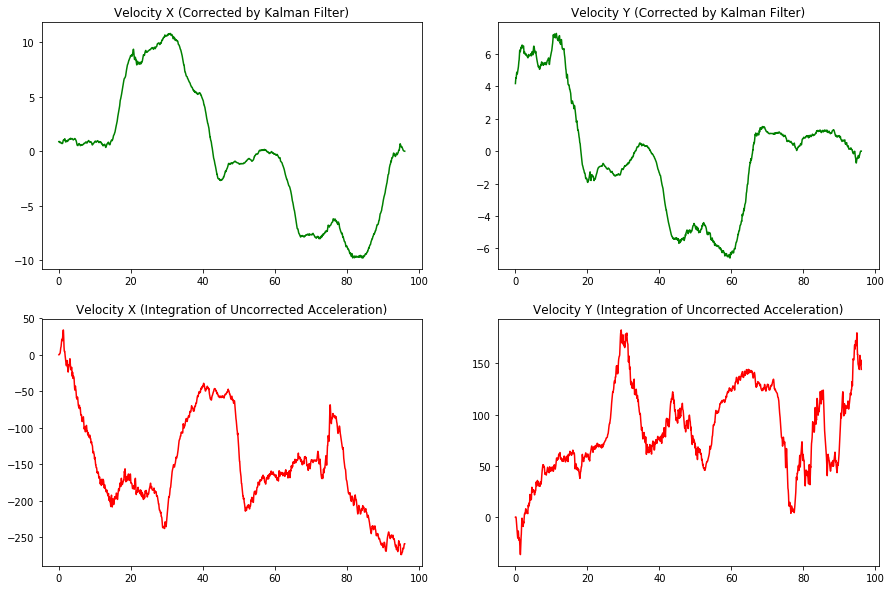

In [14]:
plt.figure(figsize=(15, 10))
ax=plt.subplot(221)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 2], 'g-')
plt.title("Velocity X (Corrected by Kalman Filter)")


ax=plt.subplot(222)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 3], 'g-')
plt.title("Velocity Y (Corrected by Kalman Filter)")


ax=plt.subplot(223)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-', )
plt.title("Velocity X (Integration of Uncorrected Acceleration)")


ax=plt.subplot(224)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.title("Velocity Y (Integration of Uncorrected Acceleration)")


## Plotting Overlay on Google Maps
https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

https://github.com/pbugnion/gmaps

https://jupyter-gmaps.readthedocs.io/en/latest/

In [15]:
import gmaps
import gmaps.datasets

f = open('apikey.txt')
a = f.readline()

gmaps.configure(api_key=a) # Your Google API key

f_layout = {'width': '900px','height': '800px','border': '1px solid black', 'padding': '1px'}
fig = gmaps.figure(layout = f_layout, center=(data.kal_latlng[0, 2], 
                                              data.kal_latlng[0, 1]), zoom_level=18, map_type='HYBRID')
lines = []

locations_kal = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng])
locations_kal.gradient = [(0, 0, 0, 0.0), (0, 255, 0, 1), (0, 128, 0, 1)]
locations_kal.max_intensity = 20
locations_kal.point_radius = 5

locations_gps = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.gps_latlng])
locations_gps.gradient = [(0, 0, 0, 0.0), (255, 0, 0, 1), (128, 0, 0 , 1)]
locations_gps.max_intensity = 20
locations_gps.point_radius = 5

# locations_gt = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.ground_truth.gps])
# locations_gt.gradient = [(0, 0, 0, 0.0), (0, 0, 255, 1), (0, 0, 128 , 1)]
# locations_gt.max_intensity = 20
# locations_gt.point_radius = 5

# Features to draw on the map
gt_lines = []
for i in range(1, len(data.ground_truth.gps)):
    gt_lines.append(gmaps.Line(start= (data.ground_truth.gps[i-1, 2], data.ground_truth.gps[i-1, 1]), 
                               end  = (data.ground_truth.gps[i  , 2], data.ground_truth.gps[i, 1]), 
                               stroke_weight = 3.0, stroke_color = 'Blue'))

gt_lines = gmaps.drawing_layer(features=gt_lines)


InvalidPointException: 90.02236012041719 is not a valid latitude. Latitudes must lie between -90 and 90.

In [7]:
fig.add_layer(locations_kal)
fig.add_layer(locations_gps)
fig.add_layer(gt_lines)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='900px'))